In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt


In [4]:
work_path = '/content/gdrive/Shared drives/marketdata/stock/'
os.chdir(work_path)

### Define Parameters

In [5]:
STOP_PROFIT = 1
STOP_LOSS = 2
TIME_OUT = 3

In [6]:
def numtotime(num):
    ms = num % 1000
    num //= 1000
    s = num % 100
    num //= 100
    mi = num % 100
    num //= 100
    h = num % 100
    num = num // 100
    # print(h, mi, s, ms)
    return dt.datetime(2020, 9, 21, h, mi, s, ms) # TODO

# Hft_strategy

In [7]:
class Hft_strategy:
    def __init__(self, lob_file, tick_file):
        self.lob_file = open(lob_file)
        self.tick_file = open(tick_file)
        self.df = pd.read_csv(tick_file)
        self.df["time"] = self.df["time"].apply(func = numtotime)
        self.df.set_index("time", inplace = True)
        self.lob_col = self.lob_file.readline()[:-1].split(",")
        self.tick_col = self.tick_file.readline()[:-1].split(",")
        self.ref_num = 0
        self.num_buy = 0
        self.num_sell = 0
        self.ask1_p = 0
        self.ask2_p = 0
        self.ask3_p = 0
        self.ask4_p = 0
        self.ask5_p = 0
        self.ask1_q = 0
        self.ask2_q = 0
        self.ask3_q = 0
        self.ask4_q = 0
        self.ask5_q = 0
        self.bid1_p = 0
        self.bid2_p = 0
        self.bid3_p = 0
        self.bid4_p = 0
        self.bid5_p = 0
        self.bid1_q = 0
        self.bid2_q = 0
        self.bid3_q = 0
        self.bid4_q = 0
        self.bid5_q = 0
        self.daily_high = 0
        self.daily_low = 10000

        self.stop_profit = 0
        self.stop_loss = 0

        self.profit = 0
        self.cost = 0

        self.num_win = 0
        self.num_loss = 0

        self.order_time = 0
        self.stop_time = None

        self.position = []
        self.current_time = 0

        self.total_cost = 0

    def get_result(self):
        return self.profit, self.total_cost, self.num_win, self.num_loss

    def lob_update(self, lob_row):
        pass

    def tick_update(self, tick_row):
        pass

    def could_buy(self):
        pass

    def buy(self):
        pass

    def could_sell(self):
        pass

    def sell(self):
        pass

    def could_order(self):
        pass
        
    def order(self):
        pass

    def task(self):
        pass
    def show_result(self):
        pass

# YY10
### Long
#### self.ask1_p < self.weighted_p * self.theta


In [23]:
class YY10(Hft_strategy):
    def __init__(self, lob_file, tick_file, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
        super().__init__(lob_file, tick_file)
        self.tick_list = []
        self.beta = beta
        self.time_out = time_out
        self.order_p = np.array([])
        self.gamma = gamma
        self.in_history = []
        self.out_history = []
        self.in_time = []
        self.out_time = []
        self.cool_down_min = cool_down_min
        self.stop_loss_factor = stop_loss_factor
        self.theta = theta
        self.weighted_p = 0
        self.total_trade_q = 0
        self.total_trade_p = 0
        self.position_max_q = position_max_q
        self.position = np.array([])

        print(self.lob_file)
        print(self.tick_file)


    def task(self):
        temp_lob = self.lob_file.readline()[:-1].split(",")
        temp_tick = self.tick_file.readline()[:-1].split(",")
        lob_row = pd.Series(data = temp_lob, index=self.lob_col)
        tick_row = pd.Series(data = temp_tick, index = self.tick_col)
        self.lob_datatype_conversion(lob_row)
        self.tick_datatype_conversion(tick_row)
        next_lob_time = lob_row['time']
        next_tick_time = tick_row['time']
        self.current_time = min(next_lob_time, next_tick_time)
        print(self.current_time)

        c = 0
        flag = 1
        while(self.current_time <= 130000000):
            # print(c)
            c += 1                        
            if (next_lob_time < next_tick_time):
                self.lob_update(lob_row)
                temp_lob = self.lob_file.readline()[:-1].split(",")
                lob_row = pd.Series(data = temp_lob, index=self.lob_col)
                self.lob_datatype_conversion(lob_row)
                next_lob_time = lob_row['time']
            else:
                self.tick_update(tick_row)
                temp_tick = self.tick_file.readline()[:-1].split(",")
                tick_row = pd.Series(data = temp_tick, index = self.tick_col)
                self.tick_datatype_conversion(tick_row)
                next_tick_time = tick_row['time']
            # print("next_lob: ", next_lob_time, "next_tick: ", next_tick_time)
            self.current_time = min(next_lob_time, next_tick_time)
            if self.could_buy():
                self.buy()
            if self.could_sell(tick_row):
                self.sell(tick_row)
            '''
            buy_type = self.could_buy(tick_row)
            if buy_type == STOP_PROFIT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.order_p)
                print("get", -self.order_p + self.cost)
                self.out_history.append(self.order_p)
                self.profit += self.cost - self.order_p 
                print("-"*30)
            elif buy_type == STOP_LOSS or buy_type == TIME_OUT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.ask1_p)
                print("get", -self.ask1_p + self.cost)
                self.out_history.append(self.ask1_p)
                self.profit += -self.ask1_p + self.cost
                print("-"*30)
            '''
        self.clear_position(tick_row)

    
    def lob_datatype_conversion(self, lob_row):
        lob_row['time'] = int(lob_row['time'])
        lob_row['ask1_price'] = float(lob_row['ask1_price'])
        lob_row['ask2_price'] = float(lob_row['ask2_price'])
        lob_row['ask3_price'] = float(lob_row['ask3_price'])
        lob_row['ask4_price'] = float(lob_row['ask4_price'])
        lob_row['ask5_price'] = float(lob_row['ask5_price'])
        lob_row['bid1_price'] = float(lob_row['bid1_price'])
        lob_row['bid2_price'] = float(lob_row['bid2_price'])
        lob_row['bid3_price'] = float(lob_row['bid3_price'])
        lob_row['bid4_price'] = float(lob_row['bid4_price'])
        lob_row['bid5_price'] = float(lob_row['bid5_price'])
        lob_row['ask1_qty'] = int(float(lob_row['ask1_qty']))
        lob_row['ask2_qty'] = int(float(lob_row['ask2_qty']))
        lob_row['ask3_qty'] = int(float(lob_row['ask3_qty']))
        lob_row['ask4_qty'] = int(float(lob_row['ask4_qty']))
        lob_row['ask5_qty'] = int(float(lob_row['ask5_qty']))
        lob_row['bid1_qty'] = int(float(lob_row['bid1_qty']))
        lob_row['bid2_qty'] = int(float(lob_row['bid2_qty']))
        lob_row['bid3_qty'] = int(float(lob_row['bid3_qty']))
        lob_row['bid4_qty'] = int(float(lob_row['bid4_qty']))
        lob_row['bid5_qty'] = int(float(lob_row['bid5_qty']))

    def tick_datatype_conversion(self, tick_row):
        tick_row['time'] = int(tick_row['time'])
        tick_row['price'] = float(tick_row['price'])
        tick_row['qty'] = int(tick_row['qty'])

    def lob_update(self, lob_row):
        self.ask1_p = lob_row['ask1_price'] 
        self.ask2_p = lob_row['ask2_price']
        self.ask3_p = lob_row['ask3_price']
        self.ask4_p = lob_row['ask4_price']
        self.ask5_p = lob_row['ask5_price']
        self.ask1_q = lob_row['ask1_qty']
        self.ask2_q = lob_row['ask2_qty']
        self.ask3_q = lob_row['ask3_qty']
        self.ask4_q = lob_row['ask4_qty']
        self.ask5_q = lob_row['ask5_qty']
        self.bid1_p = lob_row['bid1_price']
        self.bid2_p = lob_row['bid2_price']
        self.bid3_p = lob_row['bid3_price']
        self.bid4_p = lob_row['bid4_price']
        self.bid5_p = lob_row['bid5_price']
        self.bid1_q = lob_row['bid1_qty']
        self.bid2_q = lob_row['bid2_qty']
        self.bid3_q = lob_row['bid3_qty']
        self.bid4_q = lob_row['bid4_qty']
        self.bid5_q = lob_row['bid5_qty']

    def tick_update(self, tick_row):
        self.daily_low = min(self.daily_low, tick_row['price'])
        self.daily_high = max(self.daily_high, tick_row['price'])
        if self.current_time > 90100000:
            self.total_trade_q += tick_row['qty'] 
            self.total_trade_p += tick_row['price'] * tick_row['qty'] 
            self.weighted_p = self.total_trade_p / self.total_trade_q

        if (tick_row['price'] >= self.ask1_p):
            tick_row['buy_or_sell'] = "buy"
            self.num_buy += tick_row['qty'] 
        elif (tick_row['price'] <= self.bid1_p):
            tick_row['buy_or_sell'] = "sell"
            self.num_sell += tick_row['qty']
        else:
            tick_row['buy_or_sell'] = "QAO"
            print("------Weird price!!!!!---------")
            print("At time: ", tick_row['time'])
            print("tick_row_price", tick_row['price'])
            print("ask_1_p", self.ask1_p)
            print("bid_1_p", self.bid1_p)
            # assert(0), "Weird price!!!!!"

        if len(self.tick_list) < 10:
            self.tick_list.append(tick_row)
        else:
            if self.tick_list[0]['buy_or_sell'] == "buy":
                self.num_buy -= self.tick_list[0]['qty']
            elif self.tick_list[0]['buy_or_sell'] == "sell":
                self.num_sell -= self.tick_list[0]['qty']
            else:
                pass
            self.tick_list.pop(0)
            self.tick_list.append(tick_row)

    def could_buy(self):
        if self.ask1_p < self.weighted_p * self.theta \
            and self.current_time >= self.order_time + self.cool_down_min \
            and len(self.position) <= self.position_max_q \
            and self.current_time > 90200000\
            and self.num_buy > self.num_sell * self.beta:
            print("*** ask1_p: ", self.ask1_p)
            print("*** weighted_p: ", self.weighted_p)
            print("bid1_p: ", self.bid1_p)
            return True
        else:
            return False

    def buy(self):
        print("進場時間：", self.current_time, "\n  buy price at ", self.ask1_p)
        print("order at", self.ask2_p)
        self.in_history.append(self.ask1_p)
        self.in_time.append(self.current_time)
        self.position = np.append(self.position, self.ask1_p)
        self.order_time = self.current_time
        self.cost = self.ask1_p
        self.order_p = np.append(self.order_p, self.ask2_p)

        self.total_cost += self.cost

    def could_sell(self, tick_row):
        # stop profit
        if len(self.position) and tick_row['price'] > np.min(self.order_p):
            print("stop profit")
            return STOP_PROFIT
        # stop loss
        return False
        # elif len(self.position) and tick_row['price'] >= self.cost * self.stop_loss_factor:
        #     print("stop loss")
        #     return STOP_LOSS
        # # time out
        # elif len(self.position) and self.current_time - self.order_time >= self.time_out:
        #     print("time out")
        #     return False
        # else:
        #     return False
        # keep position

        # no position

    def sell(self, tick_row):
        print("出場時間：", self.current_time)
        self.out_history.append(tick_row['price'])
        self.out_time.append(self.current_time)
        print("POSITION(pre): ", self.position)
        print("Order_p(pre): ", self.order_p)
        print("tick_row price: ", tick_row['price'])
        buy_index = np.argwhere(self.order_p < tick_row['price'])
        print("qualified index: ", buy_index)
        self.profit += (-self.position+self.order_p)[buy_index].sum()
        self.position = np.delete(self.position, buy_index)
        self.order_p = np.delete(self.order_p, buy_index)
        print("POSITION(post): ", self.position)
        print("Order_p(post): ", self.order_p)
        print()

        # self.order_time = self.current_time
        
    def clear_position(self, tick_row):
        print("clear_position: ", np.sum(-self.position+tick_row["price"]))
        print("position: ", self.position)
        print("tick_row_price", tick_row["price"])
        self.profit += np.sum(-self.position+tick_row["price"])
            

    def show_result(self):
        print("----------Result Report--------------")
        print("profit: ", self.profit)
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.title("price")
        
        plt.scatter([numtotime(x) for x in self.in_time], self.in_history, marker='^', s= 144, c="red")
        plt.scatter([numtotime(x) for x in self.out_time], self.out_history, marker='v', s = 144, c="lime")
        plt.plot(self.df.index, self.df.loc[:, 'price'])
        plt.subplot(212)
        #plt.figure(figsize=(20,10))
        plt.title("qty")
        plt.plot(self.df.index, self.df.loc[:, "qty"])
        
        plt.show()

    

#### back_test

In [24]:
import datetime as dt


def back_test(start_date, end_date, sid, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
    
    cur_day = None
    result_list = []
    for file in sorted(os.listdir()):
        if "zip" not in file:
            # print(file)
            year, month, date = [int(x) for x in file.split("-")]

            cur_day = dt.datetime(year, month, date)
            if end_date >= cur_day >= start_date:
                sid_type = "otc"
                lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")

                if not os.path.exists(lob_path):
                    sid_type = "tse"
                    lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                    tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")
                temp = YY10(lob_path, tick_path, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q)
                temp.task()
                result_list.append(temp.get_result())
                temp.show_result()
                with open("../result_YY10.csv", "a") as f:
                    f.write("\n")
                    f.write(",".join([str(x) for x in ["YY10", cur_day, sid, beta, time_out, gamma, \
                                                    cool_down_min, stop_loss_factor, theta, position_max_q, temp.profit, temp.total_cost]]))
                        
    return result_list 

def calculate_profit(res_list):
    s = 0
    c = 0
    for x in res_list:
        s+=x[0]
        c+=x[1]
    return s, c


#### RUN

# grid search

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-01/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-01/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90009370
*** ask1_p:  117.0
*** weighted_p:  117.89240506329114
bid1_p:  116.5
進場時間： 91042826 
  buy price at  117.0
order at 117.5
*** ask1_p:  117.0
*** weighted_p:  117.76989079563182
bid1_p:  116.5
進場時間： 91101166 
  buy price at  117.0
order at 117.5
*** ask1_p:  116.0
*** weighted_p:  117.16582914572864
bid1_p:  115.5
進場時間： 91304408 
  buy price at  116.0
order at 116.5
*** ask1_p:  115.0
*** weighted_p:  116.85763000852515
bid1_p:  114.5
進場時間： 91403306 
  buy price at  115.0
order at 115.5
*** ask1_p:  115.0
*** weighted_p:  116.66848249027237
bid1_p:  114.5
進場時間： 91503861 
  buy price at  115.0
order at 115.5
stop profit
出場時間： 91534432
POSITION(pre):  [117. 117. 116. 115. 115.]
Order_p(pre):  [117.5 117.5 116.5 115.5

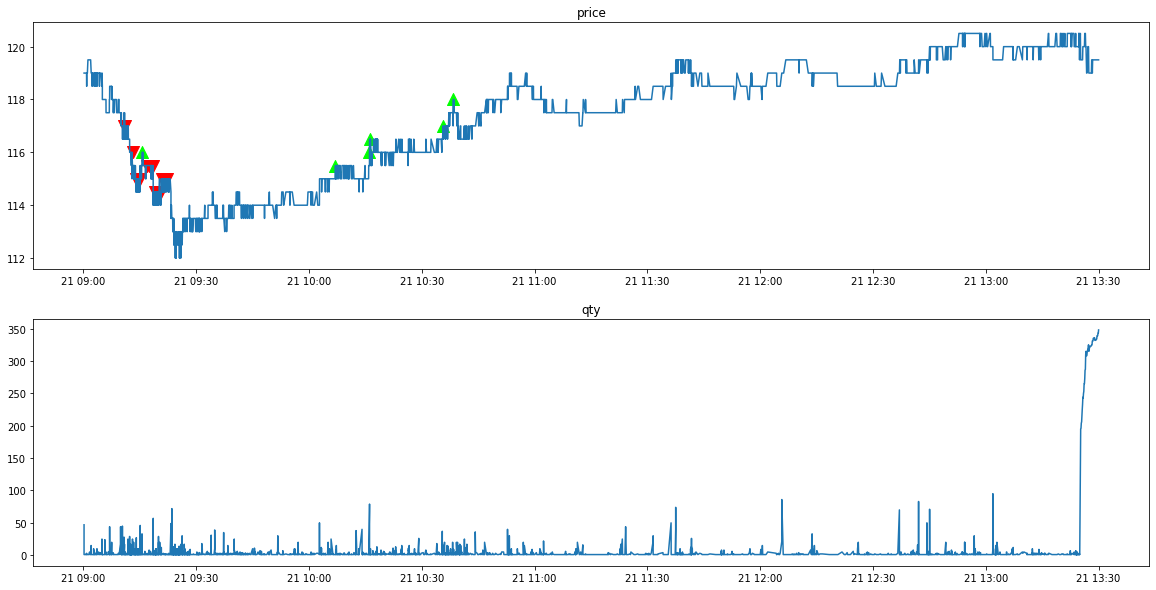

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-02/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-02/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90003626
*** ask1_p:  121.0
*** weighted_p:  121.75243081525804
bid1_p:  120.5
進場時間： 91633050 
  buy price at  121.0
order at 121.5
*** ask1_p:  121.0
*** weighted_p:  121.60912698412699
bid1_p:  120.5
進場時間： 91906504 
  buy price at  121.0
order at 121.5
stop profit
出場時間： 92602586
POSITION(pre):  [121. 121.]
Order_p(pre):  [121.5 121.5]
tick_row price:  122.0
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** ask1_p:  119.5
*** weighted_p:  121.18114001530222
bid1_p:  119.0
進場時間： 100231420 
  buy price at  119.5
order at 120.0
*** ask1_p:  119.0
*** weighted_p:  121.05325656711047
bid1_p:  118.5
進場時間： 100509993 
  buy price at  119.0
order at 119.5
*** ask1_p:  119.5
*** weighted_p:  121.03622412562456

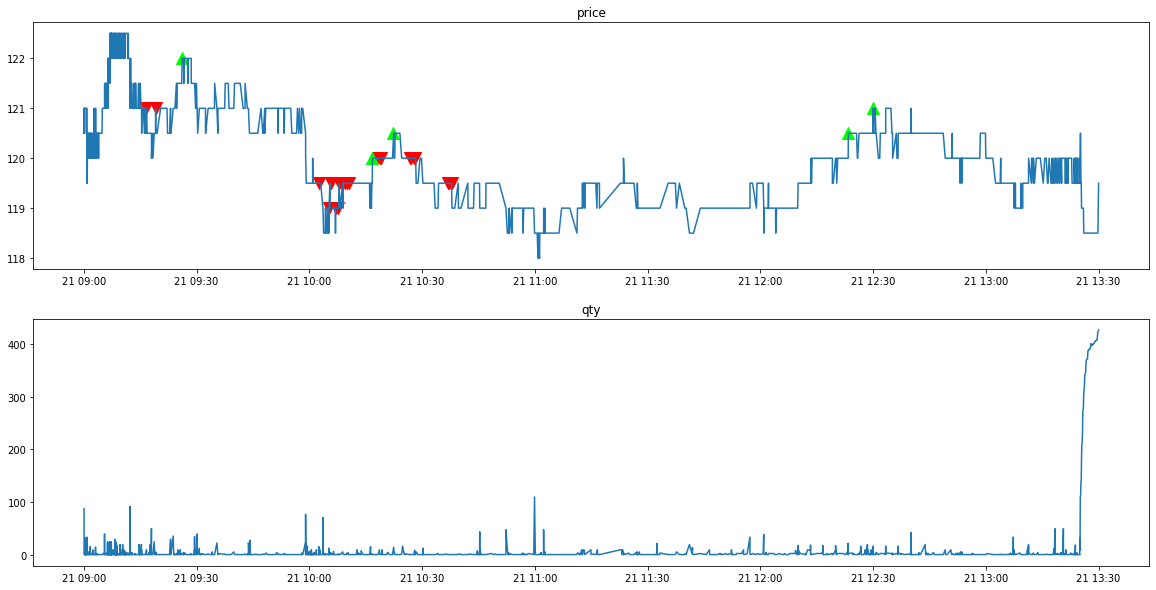

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-03/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-03/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90005938
*** ask1_p:  121.0
*** weighted_p:  121.99316874400768
bid1_p:  120.5
進場時間： 123925645 
  buy price at  121.0
order at 121.5
*** ask1_p:  121.0
*** weighted_p:  121.9926928605654
bid1_p:  120.5
進場時間： 123955989 
  buy price at  121.0
order at 121.5
*** ask1_p:  121.0
*** weighted_p:  121.99245508982035
bid1_p:  120.5
進場時間： 124002612 
  buy price at  121.0
order at 121.5
*** ask1_p:  121.0
*** weighted_p:  121.99126794258373
bid1_p:  120.5
進場時間： 124101334 
  buy price at  121.0
order at 121.5
*** ask1_p:  121.0
*** weighted_p:  121.99103085386271
bid1_p:  120.5
進場時間： 124133219 
  buy price at  121.0
order at 121.5
*** ask1_p:  121.0
*** weighted_p:  121.98382877526754
bid1_p:  120.5
進場時間： 125058481 
  buy price at  12

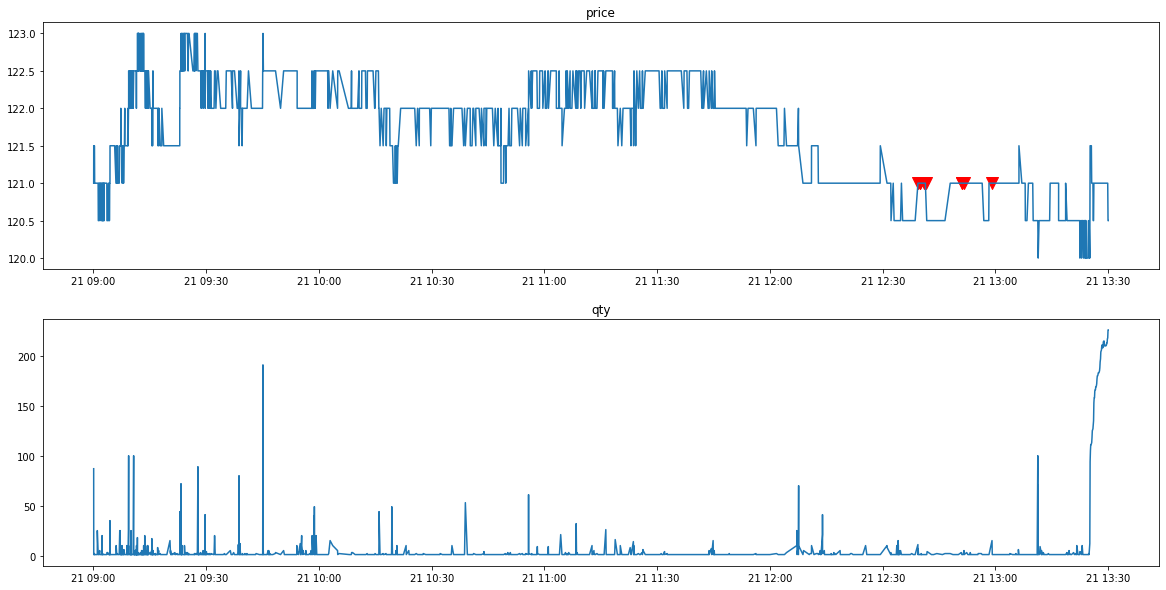

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-04/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-04/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90008807
clear_position:  0.0
position:  []
tick_row_price 123.5
----------Result Report--------------
profit:  0.0


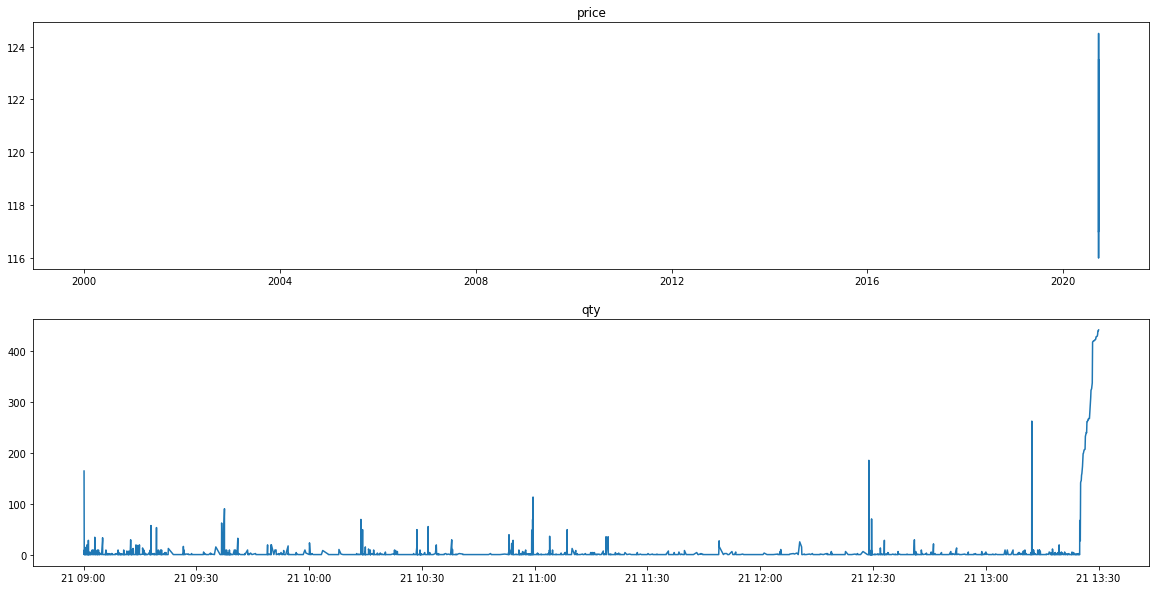

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-07/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-07/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90006382
*** ask1_p:  123.5
*** weighted_p:  124.29469273743017
bid1_p:  123.0
進場時間： 90636772 
  buy price at  123.5
order at 124.0
stop profit
出場時間： 90859299
POSITION(pre):  [123.5]
Order_p(pre):  [124.]
tick_row price:  124.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** ask1_p:  122.0
*** weighted_p:  123.61479250334672
bid1_p:  121.5
進場時間： 92347512 
  buy price at  122.0
order at 122.5
*** ask1_p:  122.5
*** weighted_p:  123.61479250334672
bid1_p:  122.0
進場時間： 92400204 
  buy price at  122.5
order at 123.0
stop profit
出場時間： 92551766
POSITION(pre):  [122.  122.5]
Order_p(pre):  [122.5 123. ]
tick_row price:  123.0
qualified index:  [[0]]
POSITION(post):  [122.5]
Order_p(post):  [123.]

*** ask1_p:  

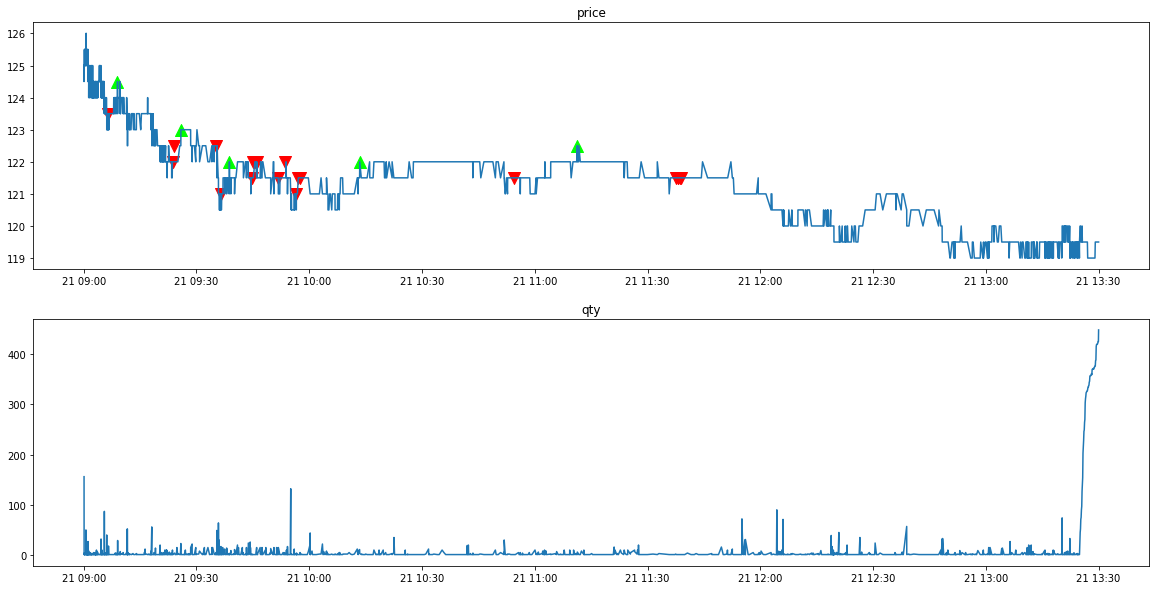

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-08/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-08/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90006522
------Weird price!!!!!---------
At time:  113827161
tick_row_price 121.0
ask_1_p 121.5
bid_1_p 120.5
*** ask1_p:  120.0
*** weighted_p:  121.18095681888785
bid1_p:  119.5
進場時間： 115040574 
  buy price at  120.0
order at 120.5
*** ask1_p:  119.0
*** weighted_p:  120.9628453038674
bid1_p:  118.5
進場時間： 120252959 
  buy price at  119.0
order at 119.5
*** ask1_p:  119.5
*** weighted_p:  120.96121998343914
bid1_p:  119.0
進場時間： 120300390 
  buy price at  119.5
order at 120.0
*** ask1_p:  120.0
*** weighted_p:  120.94449001914137
bid1_p:  119.0
進場時間： 120410961 
  buy price at  120.0
order at 120.5
*** ask1_p:  119.5
*** weighted_p:  120.9431693989071
bid1_p:  119.0
進場時間： 120441128 
  buy price at  119.5
order at 120.0
*** a

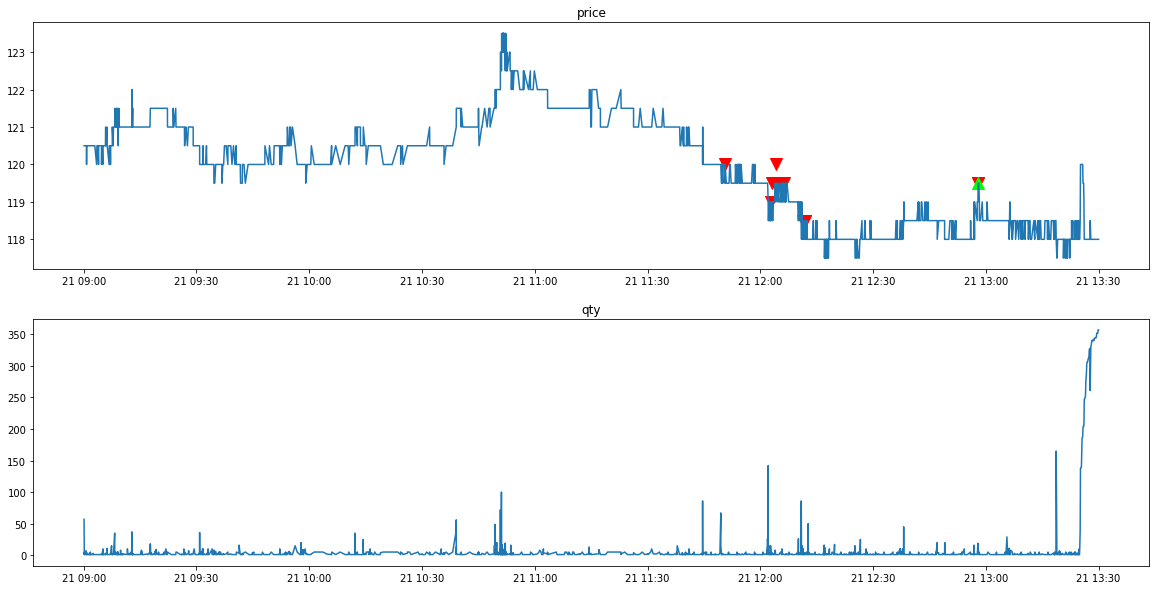

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90007702
*** ask1_p:  115.0
*** weighted_p:  115.99708624708624
bid1_p:  114.5
進場時間： 91022738 
  buy price at  115.0
order at 115.5
*** ask1_p:  115.0
*** weighted_p:  115.9216738197425
bid1_p:  114.5
進場時間： 91135762 
  buy price at  115.0
order at 115.5
*** ask1_p:  115.0
*** weighted_p:  115.89884696016772
bid1_p:  114.5
進場時間： 91211151 
  buy price at  115.0
order at 115.5
stop profit
出場時間： 91335287
POSITION(pre):  [115. 115. 115.]
Order_p(pre):  [115.5 115.5 115.5]
tick_row price:  116.0
qualified index:  [[0]
 [1]
 [2]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 119.0
----------Result Report--------------
profit:  1.5


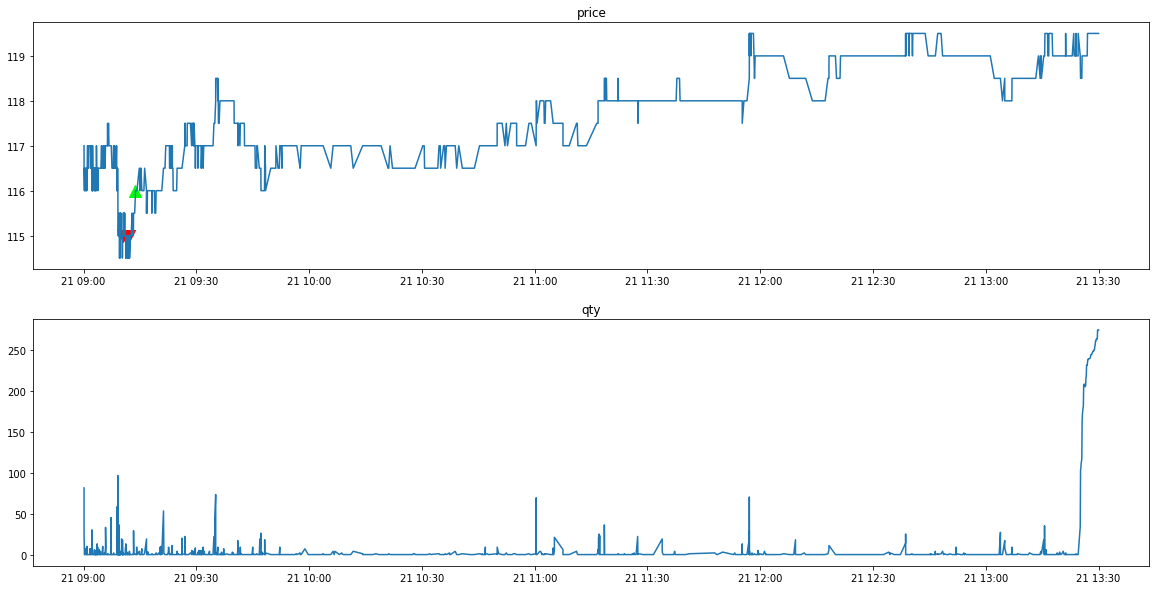

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90009523
*** ask1_p:  120.5
*** weighted_p:  121.37301038062284
bid1_p:  120.0
進場時間： 114624091 
  buy price at  120.5
order at 121.0
*** ask1_p:  120.5
*** weighted_p:  121.37253545485991
bid1_p:  120.0
進場時間： 114654277 
  buy price at  120.5
order at 121.0
*** ask1_p:  120.5
*** weighted_p:  121.37158658831663
bid1_p:  120.0
進場時間： 114701460 
  buy price at  120.5
order at 121.0
*** ask1_p:  120.5
*** weighted_p:  121.36610519078721
bid1_p:  120.0
進場時間： 114845746 
  buy price at  120.5
order at 121.0
*** ask1_p:  120.5
*** weighted_p:  121.36491589426709
bid1_p:  120.0
進場時間： 114934261 
  buy price at  120.5
order at 121.0
*** ask1_p:  120.5
*** weighted_p:  121.36385459533608
bid1_p:  120.0
進場時間： 115000052 
  buy price at  1

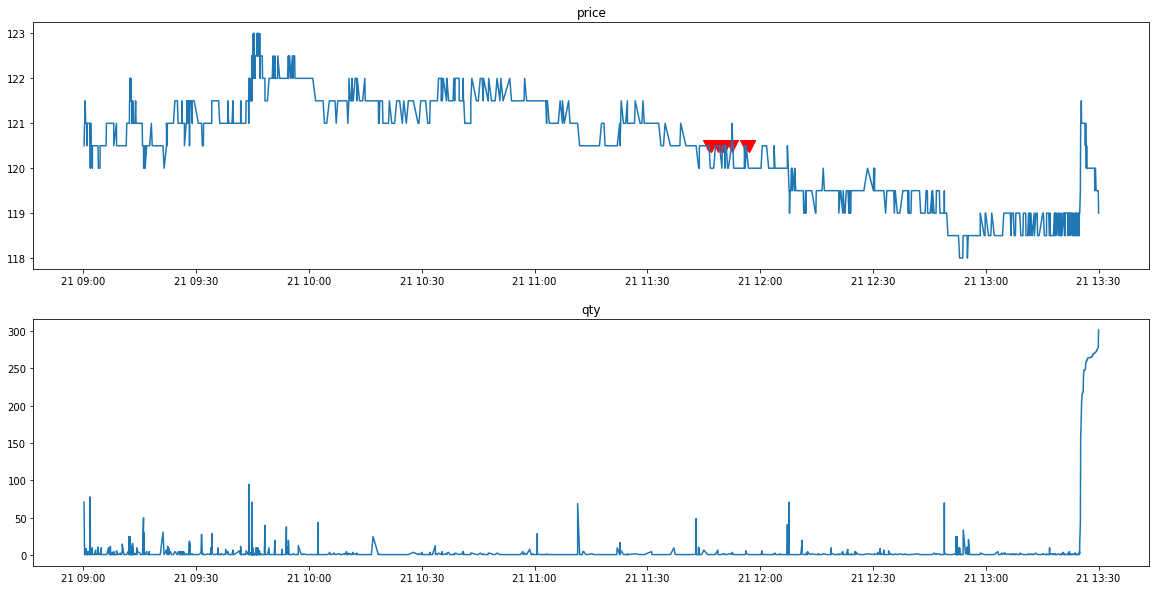

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90008401
*** ask1_p:  118.0
*** weighted_p:  118.60273081924578
bid1_p:  117.5
進場時間： 92608231 
  buy price at  118.0
order at 118.5
stop profit
出場時間： 92716402
POSITION(pre):  [118.]
Order_p(pre):  [118.5]
tick_row price:  119.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 119.0
----------Result Report--------------
profit:  0.5


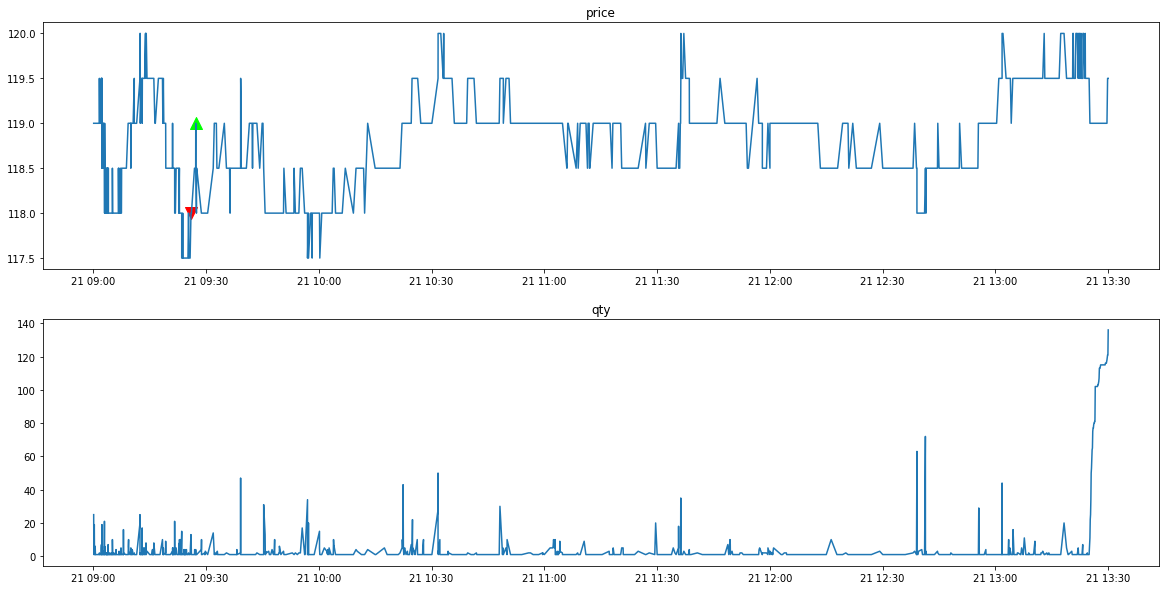

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90009325
clear_position:  0.0
position:  []
tick_row_price 124.0
----------Result Report--------------
profit:  0.0


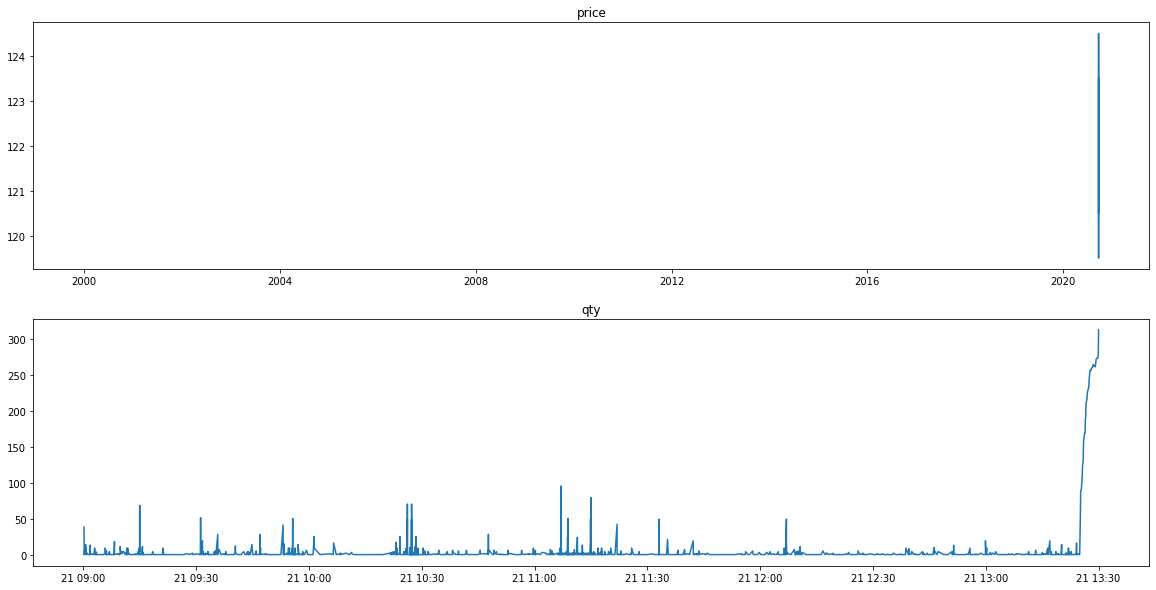

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90006445
*** ask1_p:  124.5
*** weighted_p:  125.45869033047735
bid1_p:  124.0
進場時間： 100247638 
  buy price at  124.5
order at 125.0
*** ask1_p:  124.5
*** weighted_p:  125.43634190077705
bid1_p:  124.0
進場時間： 100613063 
  buy price at  124.5
order at 125.0
*** ask1_p:  123.5
*** weighted_p:  125.2937465715853
bid1_p:  123.0
進場時間： 100901147 
  buy price at  123.5
order at 124.0
*** ask1_p:  124.0
*** weighted_p:  125.25133689839572
bid1_p:  123.5
進場時間： 101133898 
  buy price at  124.0
order at 124.5
stop profit
出場時間： 101133898
POSITION(pre):  [124.5 124.5 123.5 124. ]
Order_p(pre):  [125.  125.  124.  124.5]
tick_row price:  124.5
qualified index:  [[2]]
POSITION(post):  [124.5 124.5 124. ]
Order_p(post):  [125.  125.  124.5

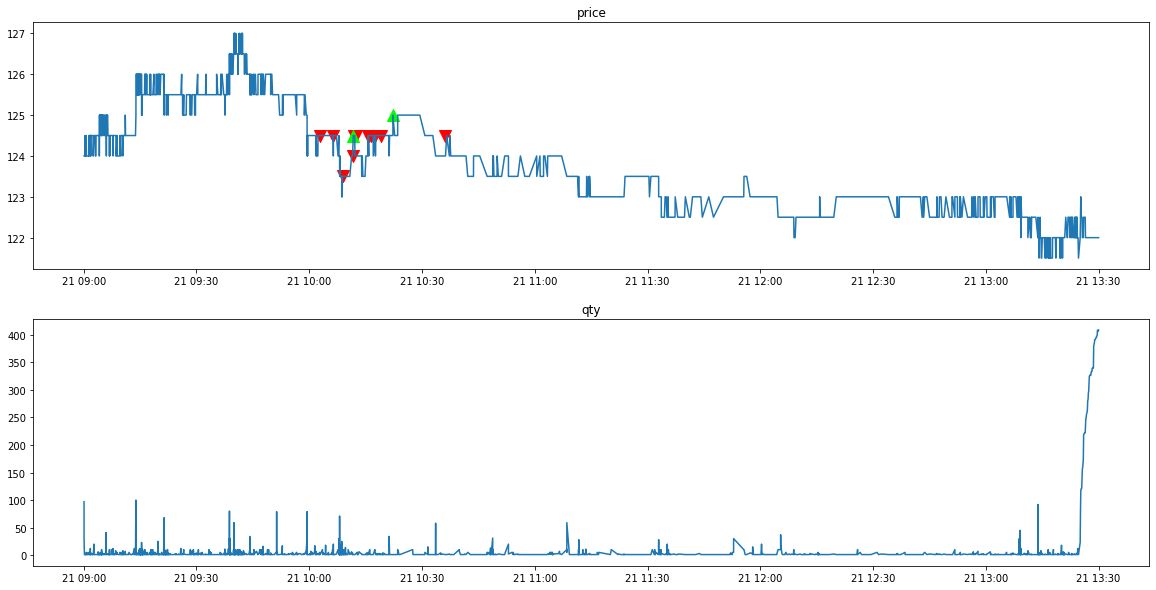

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90004725
*** ask1_p:  123.0
*** weighted_p:  123.65956151035323
bid1_p:  122.5
進場時間： 95547119 
  buy price at  123.0
order at 123.5
*** ask1_p:  123.0
*** weighted_p:  123.6587591240876
bid1_p:  122.5
進場時間： 95604832 
  buy price at  123.0
order at 123.5
stop profit
出場時間： 100305556
POSITION(pre):  [123. 123.]
Order_p(pre):  [123.5 123.5]
tick_row price:  124.0
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** ask1_p:  122.5
*** weighted_p:  123.52583423035522
bid1_p:  122.0
進場時間： 123712318 
  buy price at  122.5
order at 123.0
*** ask1_p:  122.5
*** weighted_p:  123.52391187533584
bid1_p:  122.0
進場時間： 123742867 
  buy price at  122.5
order at 123.0
*** ask1_p:  122.5
*** weighted_p:  123.52254428341385

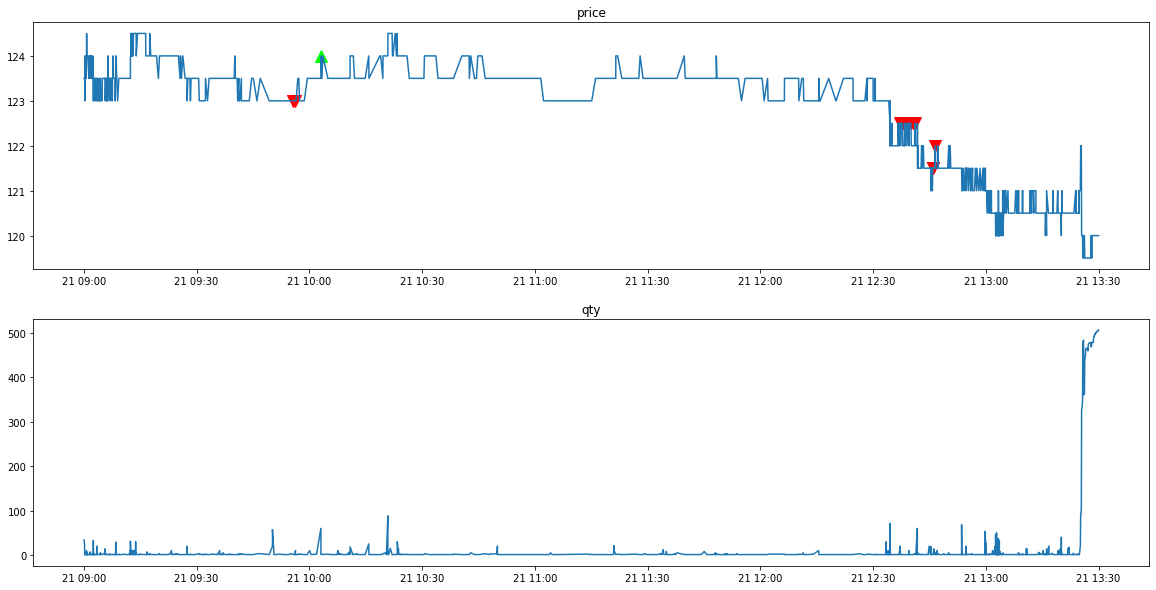

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90007157
clear_position:  0.0
position:  []
tick_row_price 122.0
----------Result Report--------------
profit:  0.0


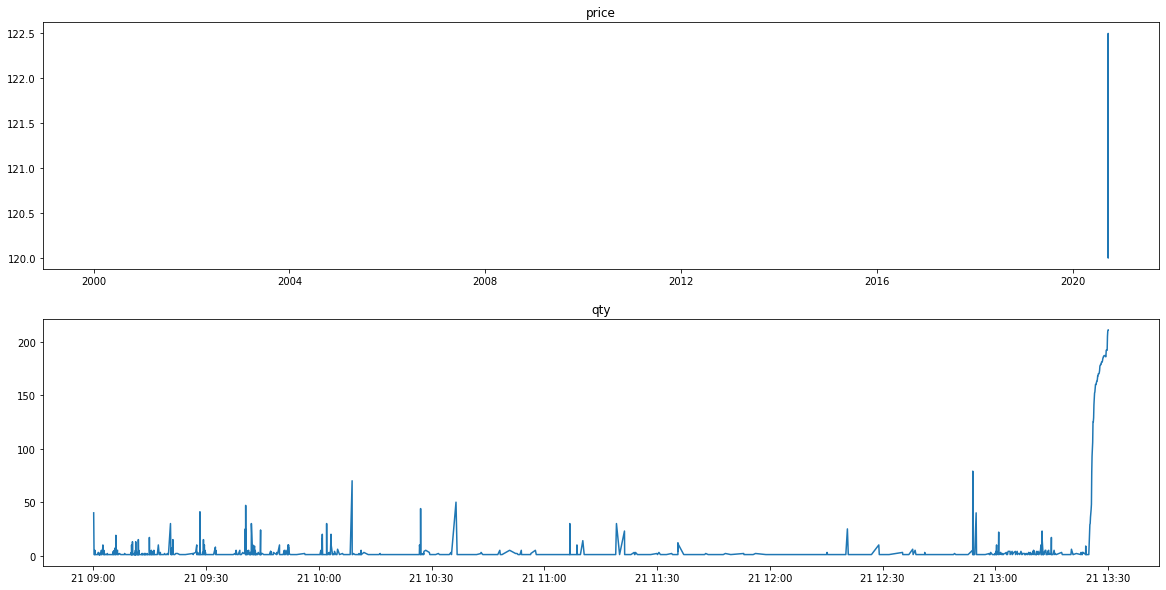

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90008684
*** ask1_p:  121.0
*** weighted_p:  121.92709599027947
bid1_p:  120.5
進場時間： 92730675 
  buy price at  121.0
order at 122.0
stop profit
出場時間： 93957627
POSITION(pre):  [121.]
Order_p(pre):  [122.]
tick_row price:  122.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 123.5
----------Result Report--------------
profit:  1.0


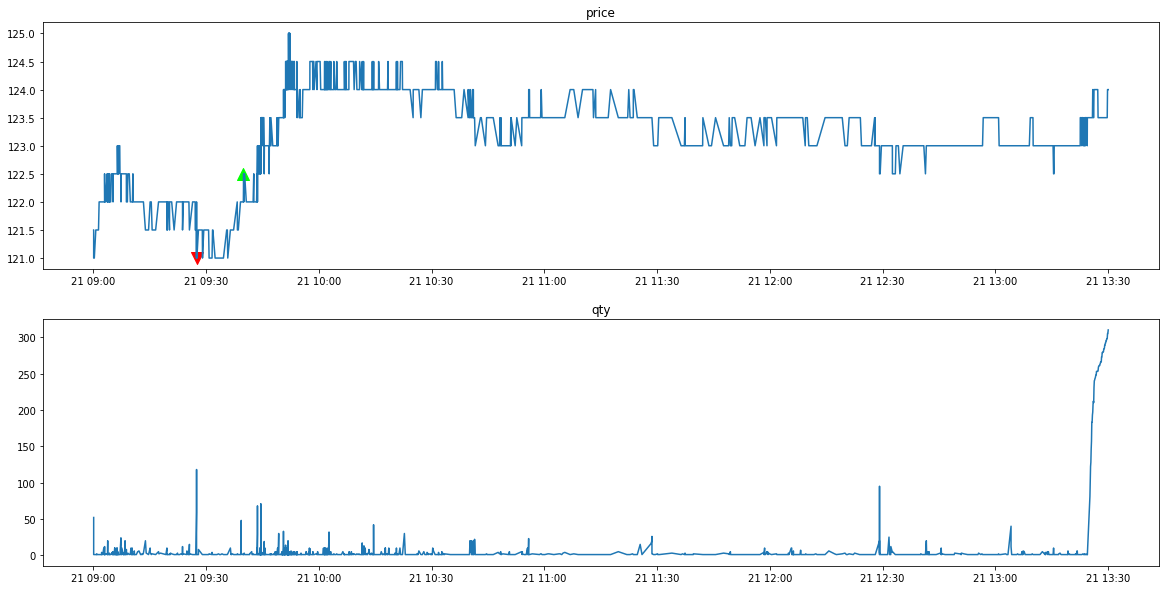

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90007181
*** ask1_p:  122.0
*** weighted_p:  122.7685676392573
bid1_p:  121.5
進場時間： 94536377 
  buy price at  122.0
order at 122.5
*** ask1_p:  122.0
*** weighted_p:  122.7685676392573
bid1_p:  121.5
進場時間： 94600990 
  buy price at  122.0
order at 122.5
*** ask1_p:  122.0
*** weighted_p:  122.76754966887417
bid1_p:  121.5
進場時間： 94635336 
  buy price at  122.0
order at 122.5
*** ask1_p:  122.0
*** weighted_p:  122.72704402515723
bid1_p:  121.5
進場時間： 94706567 
  buy price at  122.0
order at 122.5
*** ask1_p:  122.0
*** weighted_p:  122.72704402515723
bid1_p:  121.5
進場時間： 94738216 
  buy price at  122.0
order at 122.5
*** ask1_p:  122.0
*** weighted_p:  122.72704402515723
bid1_p:  121.5
進場時間： 94802170 
  buy price at  122.0
ord

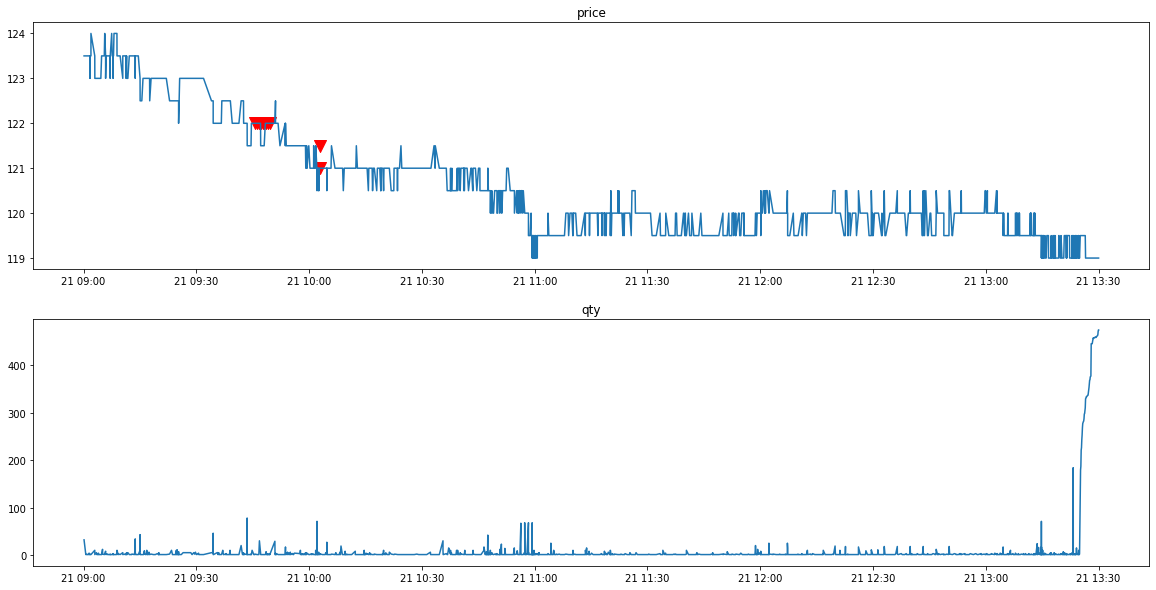

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90007635
*** ask1_p:  116.5
*** weighted_p:  117.09249471458774
bid1_p:  116.0
進場時間： 91356815 
  buy price at  116.5
order at 117.0
*** ask1_p:  115.0
*** weighted_p:  116.4622248661511
bid1_p:  114.5
進場時間： 92141702 
  buy price at  115.0
order at 115.5
*** ask1_p:  115.0
*** weighted_p:  116.4298194525335
bid1_p:  114.5
進場時間： 92217957 
  buy price at  115.0
order at 115.5
*** ask1_p:  114.5
*** weighted_p:  116.246712256707
bid1_p:  114.0
進場時間： 92326205 
  buy price at  114.5
order at 115.0
stop profit
出場時間： 92354860
POSITION(pre):  [116.5 115.  115.  114.5]
Order_p(pre):  [117.  115.5 115.5 115. ]
tick_row price:  115.5
qualified index:  [[3]]
POSITION(post):  [116.5 115.  115. ]
Order_p(post):  [117.  115.5 115.5]

*** a

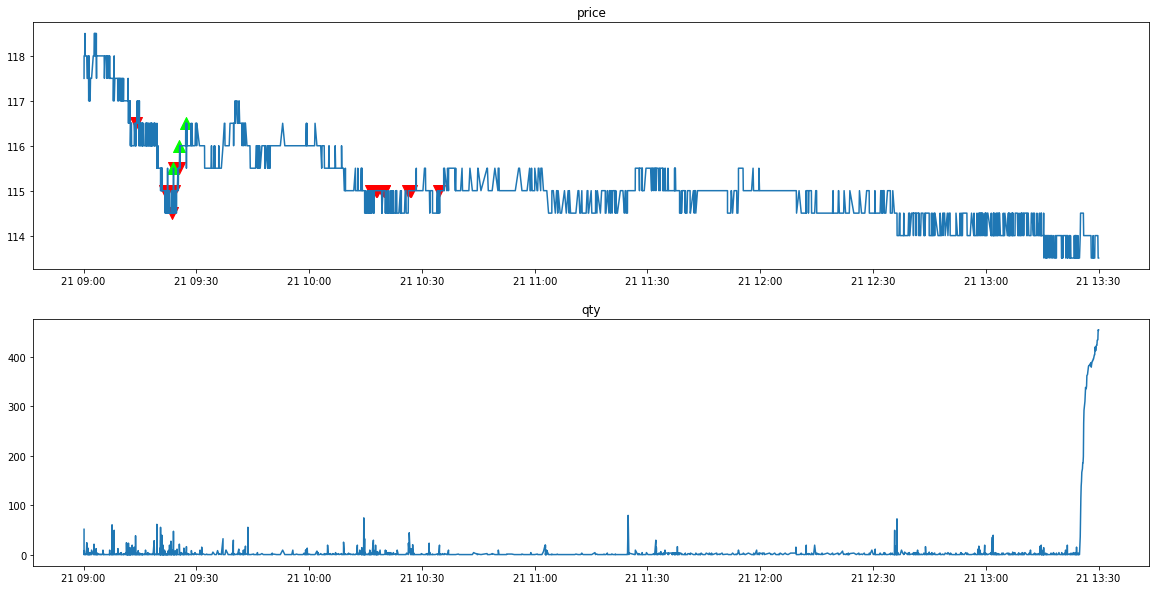

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90005184
*** ask1_p:  111.5
*** weighted_p:  112.47120786516854
bid1_p:  111.0
進場時間： 90616072 
  buy price at  111.5
order at 112.0
stop profit
出場時間： 90705429
POSITION(pre):  [111.5]
Order_p(pre):  [112.]
tick_row price:  112.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** ask1_p:  111.5
*** weighted_p:  112.25274988043998
bid1_p:  111.0
進場時間： 91545028 
  buy price at  111.5
order at 112.0
*** ask1_p:  111.5
*** weighted_p:  112.25071564885496
bid1_p:  111.0
進場時間： 91600032 
  buy price at  111.5
order at 112.0
*** ask1_p:  111.5
*** weighted_p:  112.1910013233348
bid1_p:  111.0
進場時間： 91823145 
  buy price at  111.5
order at 112.0
*** ask1_p:  111.5
*** weighted_p:  112.1830493665356
bid1_p:  111.0
進場時間

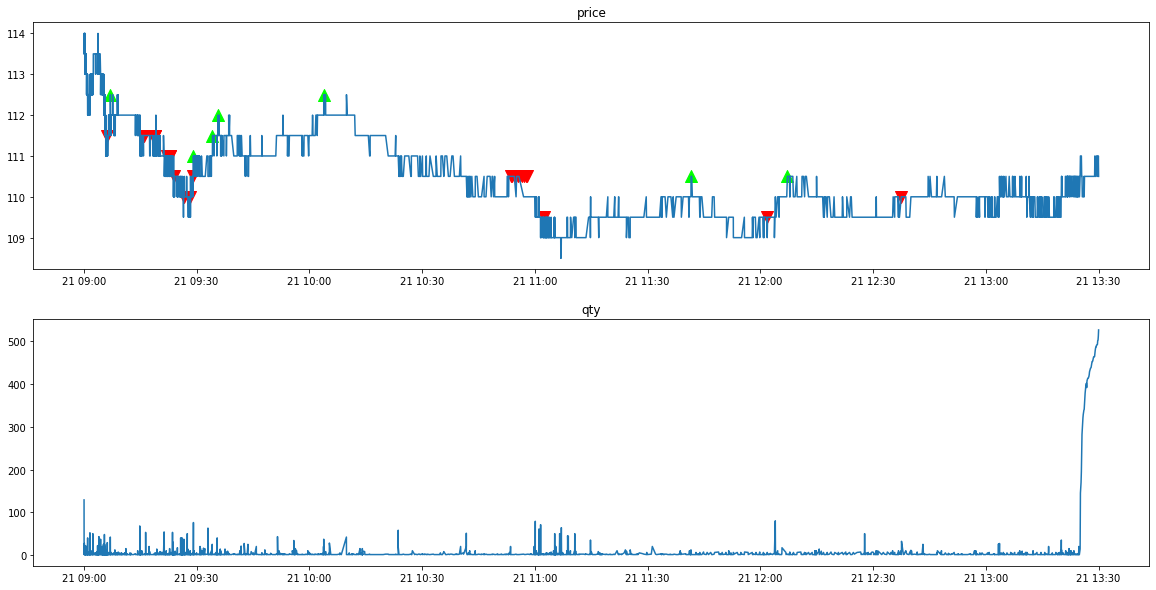

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90003100
*** ask1_p:  107.0
*** weighted_p:  107.54297407912688
bid1_p:  106.5
進場時間： 94042596 
  buy price at  107.0
order at 107.5
*** ask1_p:  106.5
*** weighted_p:  107.45200333889817
bid1_p:  106.0
進場時間： 94315563 
  buy price at  106.5
order at 107.0
*** ask1_p:  106.0
*** weighted_p:  107.18691899070384
bid1_p:  105.5
進場時間： 95328524 
  buy price at  106.0
order at 106.5
*** ask1_p:  106.5
*** weighted_p:  107.17230062356415
bid1_p:  106.0
進場時間： 95359015 
  buy price at  106.5
order at 107.0
*** ask1_p:  106.0
*** weighted_p:  107.09835301429459
bid1_p:  105.5
進場時間： 95705693 
  buy price at  106.0
order at 106.5
*** ask1_p:  105.5
*** weighted_p:  106.97651296829972
bid1_p:  105.0
進場時間： 95940103 
  buy price at  105.5
o

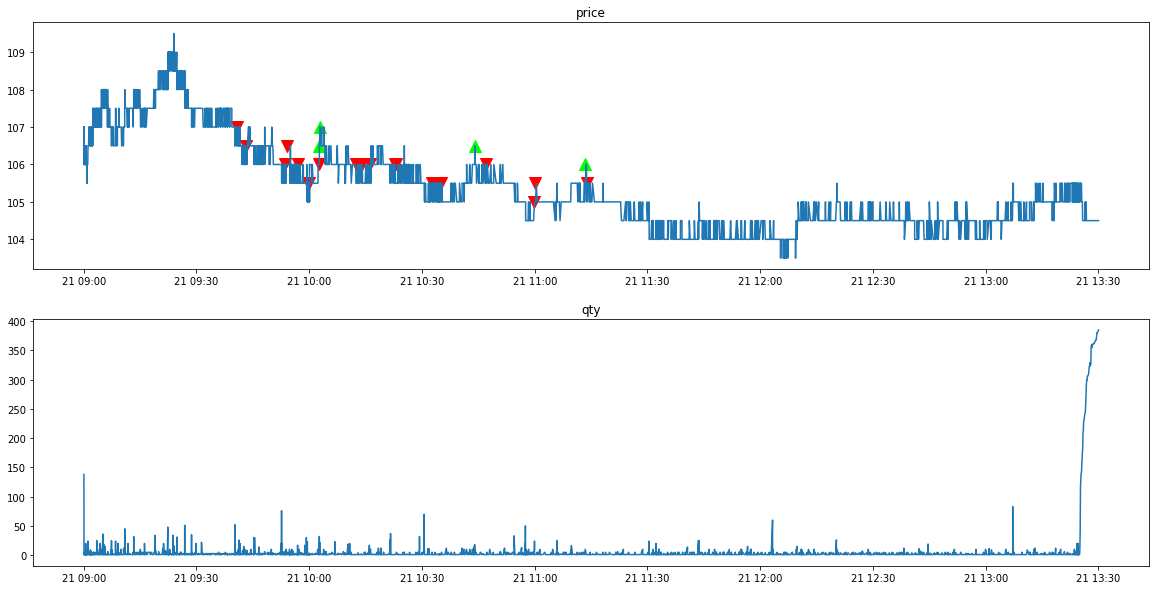

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90006331
*** ask1_p:  104.5
*** weighted_p:  105.61445427728614
bid1_p:  104.0
進場時間： 93809448 
  buy price at  104.5
order at 105.0
*** ask1_p:  104.5
*** weighted_p:  105.59494773519164
bid1_p:  104.0
進場時間： 93845029 
  buy price at  104.5
order at 105.0
*** ask1_p:  104.5
*** weighted_p:  105.54860335195531
bid1_p:  104.0
進場時間： 93926256 
  buy price at  104.5
order at 105.0
*** ask1_p:  104.5
*** weighted_p:  105.50617615467239
bid1_p:  104.0
進場時間： 94241130 
  buy price at  104.5
order at 105.0
*** ask1_p:  104.5
*** weighted_p:  105.50187265917603
bid1_p:  104.0
進場時間： 94313329 
  buy price at  104.5
order at 105.0
*** ask1_p:  104.5
*** weighted_p:  105.4912559618442
bid1_p:  104.0
進場時間： 94417758 
  buy price at  104.5
or

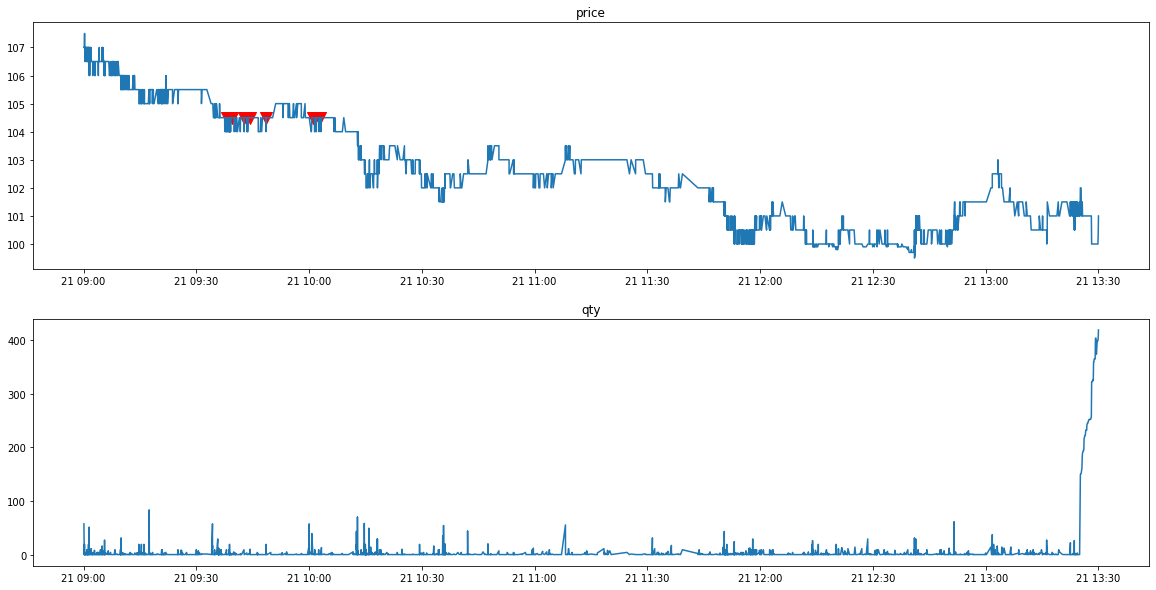

In [25]:
STOCK_LIST = ["6462", "6278", "6488", "3037", "2330", "3406", "2317", "6505", "2412", "1301", "1326", "2882", "1303", "2881", "3008", "1216", "2891", "2002", "3045", "2454", "2886", "2912", "2308", "3711", "2892"]
SEC = 1000
MIN = 100000
COOL_DOWN_MIN_LIST = [30*SEC, 45*SEC, 1*MIN, (2*MIN + 30*SEC) , 5*MIN, 10*MIN]
THETA_LIST = [0.995, 0.99, 0.98] 
sid = '6278'
res = None
for i in range(1):
# for sid in STOCK_LIST[:1]:
    for theta in THETA_LIST[:1]:
        for cool in COOL_DOWN_MIN_LIST[:1]:
            para = {"sid": sid, "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": cool, "stop_loss_factor": 1.02, "theta": theta, "position_max_q": 10}
            res = back_test(dt.datetime(2020, 9, 1), dt.datetime(2020, 9, 25), **para)
            profit, cost = calculate_profit(res)

In [26]:
profit, cost = calculate_profit(res)

In [27]:
profit

-127.5

In [28]:
cost

24007.5